# Stage-1-Visualization

In [39]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

%pylab inline
import matplotlib.image as mpimg

import os
import sys
import glob
import warnings

# Reload changed modules every time
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
sys.path.insert(0, '/mnt/rds/redhen/gallina/home/hxm471/'\
                'RedHenLab-Multimodal_TV_Show_Segmentation/mtvss/')
import constants as const
sys.path.insert(0, '/mnt/rds/redhen/gallina/home/hxm471/'\
                'RedHenLab-Multimodal_TV_Show_Segmentation/mtvss/pipeline_stage1')
from model import Model

In [3]:
# Print out hxm471 scratch path
const.SCRATCH_PATH

'/scratch/users/hxm471/'

In [4]:
file_path = '1996-01-11_0000_US_00017994_V1_VHS46_MB21_H9_WR_image_filtered.csv'

## Load in CSV as DataFrame 

In [5]:
image_filtered_df = pd.read_csv(const.SCRATCH_PATH+'tmp/'+file_path)
image_filtered_df

Unnamed: 0          label     start       end  confidence
0             0     Commercial   3216.18   3218.98    0.670505
1             1     Commercial   3252.04   3254.48    0.981389
2             2     Commercial   3281.38   3293.22    0.756534
3             3     Commercial   3305.18   3308.62    0.789015
4             4  TitleSequence   3463.66   3466.06    0.541494
..          ...            ...       ...       ...         ...
244         244     Commercial  21531.52  21543.58    0.883417
245         245     Commercial  21547.66  21562.06    0.877022
246         246     Commercial  21761.36  21779.50    0.995632
247         247  TitleSequence  21785.44  21799.34    0.719519
248         248  TitleSequence  21916.08  21921.00    0.973172

[249 rows x 5 columns]

## Visualizations

<AxesSubplot:>

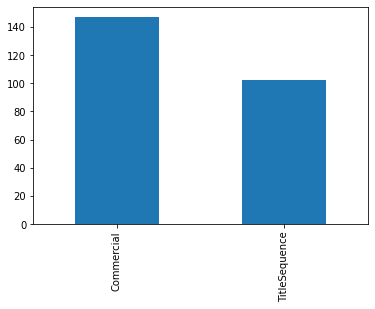

In [6]:
image_filtered_df['label'].value_counts().plot(kind='bar')

In [7]:
(image_filtered_df['confidence']<=0.9).sum()

135

<AxesSubplot:xlabel='start', ylabel='confidence'>

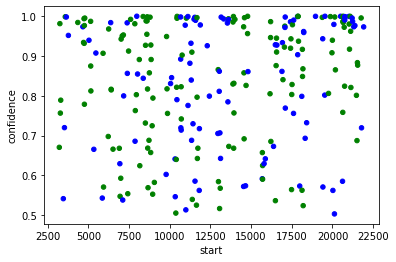

In [8]:
colors = {'Commercial':'green','TitleSequence':'blue'}
image_filtered_df.plot('start','confidence',kind='scatter',
                       c=image_filtered_df['label'].map(colors))

## Clean DataFrame 

In [9]:
image_filtered_clean_df = image_filtered_df['confidence'] > 0.95
image_filtered_clean_df = image_filtered_df.loc[image_filtered_clean_df]
image_filtered_clean_df

Unnamed: 0          label     start       end  confidence
1             1     Commercial   3252.04   3254.48    0.981389
6             6     Commercial   3583.36   3589.02    0.998626
7             7  TitleSequence   3649.82   3657.18    0.998161
8             8  TitleSequence   3773.98   3778.24    0.951771
9             9     Commercial   4354.24   4360.14    0.984307
..          ...            ...       ...       ...         ...
239         239  TitleSequence  21238.66  21244.88    0.986732
240         240  TitleSequence  21310.22  21376.82    0.973453
241         241  TitleSequence  21378.40  21457.84    0.976454
246         246     Commercial  21761.36  21779.50    0.995632
248         248  TitleSequence  21916.08  21921.00    0.973172

[84 rows x 5 columns]

<AxesSubplot:xlabel='start', ylabel='confidence'>

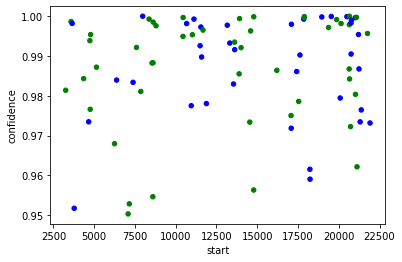

In [10]:
image_filtered_clean_df.plot('start','confidence',kind='scatter',
                       c=image_filtered_clean_df['label'].map(colors))

## Extract Keyframes

In [43]:
from decord import VideoReader
from decord import gpu, cpu
mp4_path = const.ROS_PATH+'1996/'+'1996-01/'+'1996-01-11/'+\
    '1996-01-11_0000_US_00017994_V1_VHS46_MB21_H9_WR.mp4'
def prediction_image_extraction(filename,start_time,stop_time):
    '''Using start and stop times provided, extract 5 keyframe images
    for prediction.

    Args:
        filename (str): Name of file being processed
        start_time (list): list of start times for music intervals.
        stop_time (list): list of stop times for music intervals.
    Returns:
        images (np.ndarray): batches of 5 keyframe images.
    '''

    vr = VideoReader(mp4_path, ctx=cpu(0))
    frame_num = len(vr)

    print(start_time)

    for idx in range(len(start_time.index)):
        timestamp = (start_time.iloc[idx],stop_time.iloc[idx])

    idx=0
    t_list = []
    frames = []
    for i in range(0,frame_num,24):
        # Check if all music timestamps have been mapped
        if idx>=len(start_time.index):
            break
        # Get timestamp range for current frame
        timestamp = vr.get_frame_timestamp(i)
        # Get timestamp of music interval at idx
        mtimestamp = (start_time.iloc[idx],stop_time.iloc[idx])
        # Check if music timestamp is within frame timestamp
        difftime = timestamp-mtimestamp
        # difftime[0] > 0 - start time falls within range 
        # difftime[1] < 0 - end time falls within range
        if(difftime[0]>0 and difftime[1]<0):
            if(idx>len(frames)-1):
                frames.append([i,i])
                t_list.append([timestamp[0],timestamp[0]])
            elif(frames[idx][1]<i):
                frames[idx][1]=i
                t_list[idx][1]=timestamp[0]
        # Start time out of range
        elif(difftime[0]<0):
            continue
        # End time out of range 
        else:
            idx+=1
            continue

    print('\n-- Keyframe Extraction --')
    print("## Length of vid:",frame_num)
    print("## Timestamps list:",t_list)
    print("## Frame mapping:",frames)
    print("## Frame mapping len:",len(frames))


    images_batch = []
    images=[]
    idx=0
    for i in frames:
        images_batch.append([])
        for j in range(1):
            if(i[0]>=i[1]):
                continue
            rand = round(random.randint(i[0],i[1]),2)
            images_batch[idx].append(rand)
        idx+=1

    # To flatten a list of lists
    images_batch_flat = [x for xs in images_batch for x in xs]
    images = vr.get_batch(images_batch_flat).asnumpy()

    return images

In [44]:
img_array = []
start_times = image_filtered_clean_df['start']
stop_times = image_filtered_clean_df['end']
img_array = prediction_image_extraction(file_path,start_times,stop_times)

len(img_array)

1       3252.04
6       3583.36
7       3649.82
8       3773.98
9       4354.24
         ...   
239    21238.66
240    21310.22
241    21378.40
246    21761.36
248    21916.08
Name: start, Length: 84, dtype: float64

-- Keyframe Extraction --
## Length of vid: 875815
## Timestamps list: [[3252.052, 3253.6536], [3583.5835, 3588.3884], [3650.05, 3656.4565], [3774.174, 3778.1782], [4354.755, 4359.5596], [4664.6646, 4668.6685], [4735.936, 4742.3423], [4756.757, 4757.5576], [4782.3823, 4787.988], [5142.7427, 5143.5435], [6249.449, 6255.055], [6375.1753, 6375.976], [7081.4814, 7083.083], [7153.5537, 7164.7646], [7384.985, 7385.7856], [7597.998, 7599.5996], [7858.2583, 7859.059], [7977.5776, 7978.3784], [8367.567, 8369.169], [8548.549, 8578.979], [8596.597, 8601.401], [8608.608, 8615.015], [8620.621, 8621.422], [8792.793, 8795.195], [10447.247, 10448.849], [10455.255, 10458.458], [10671.472, 10672.272], [10952.553, 10954.154], [11023.824, 11027.828], [11118.318, 11123.123], [11495.495, 11500.

81

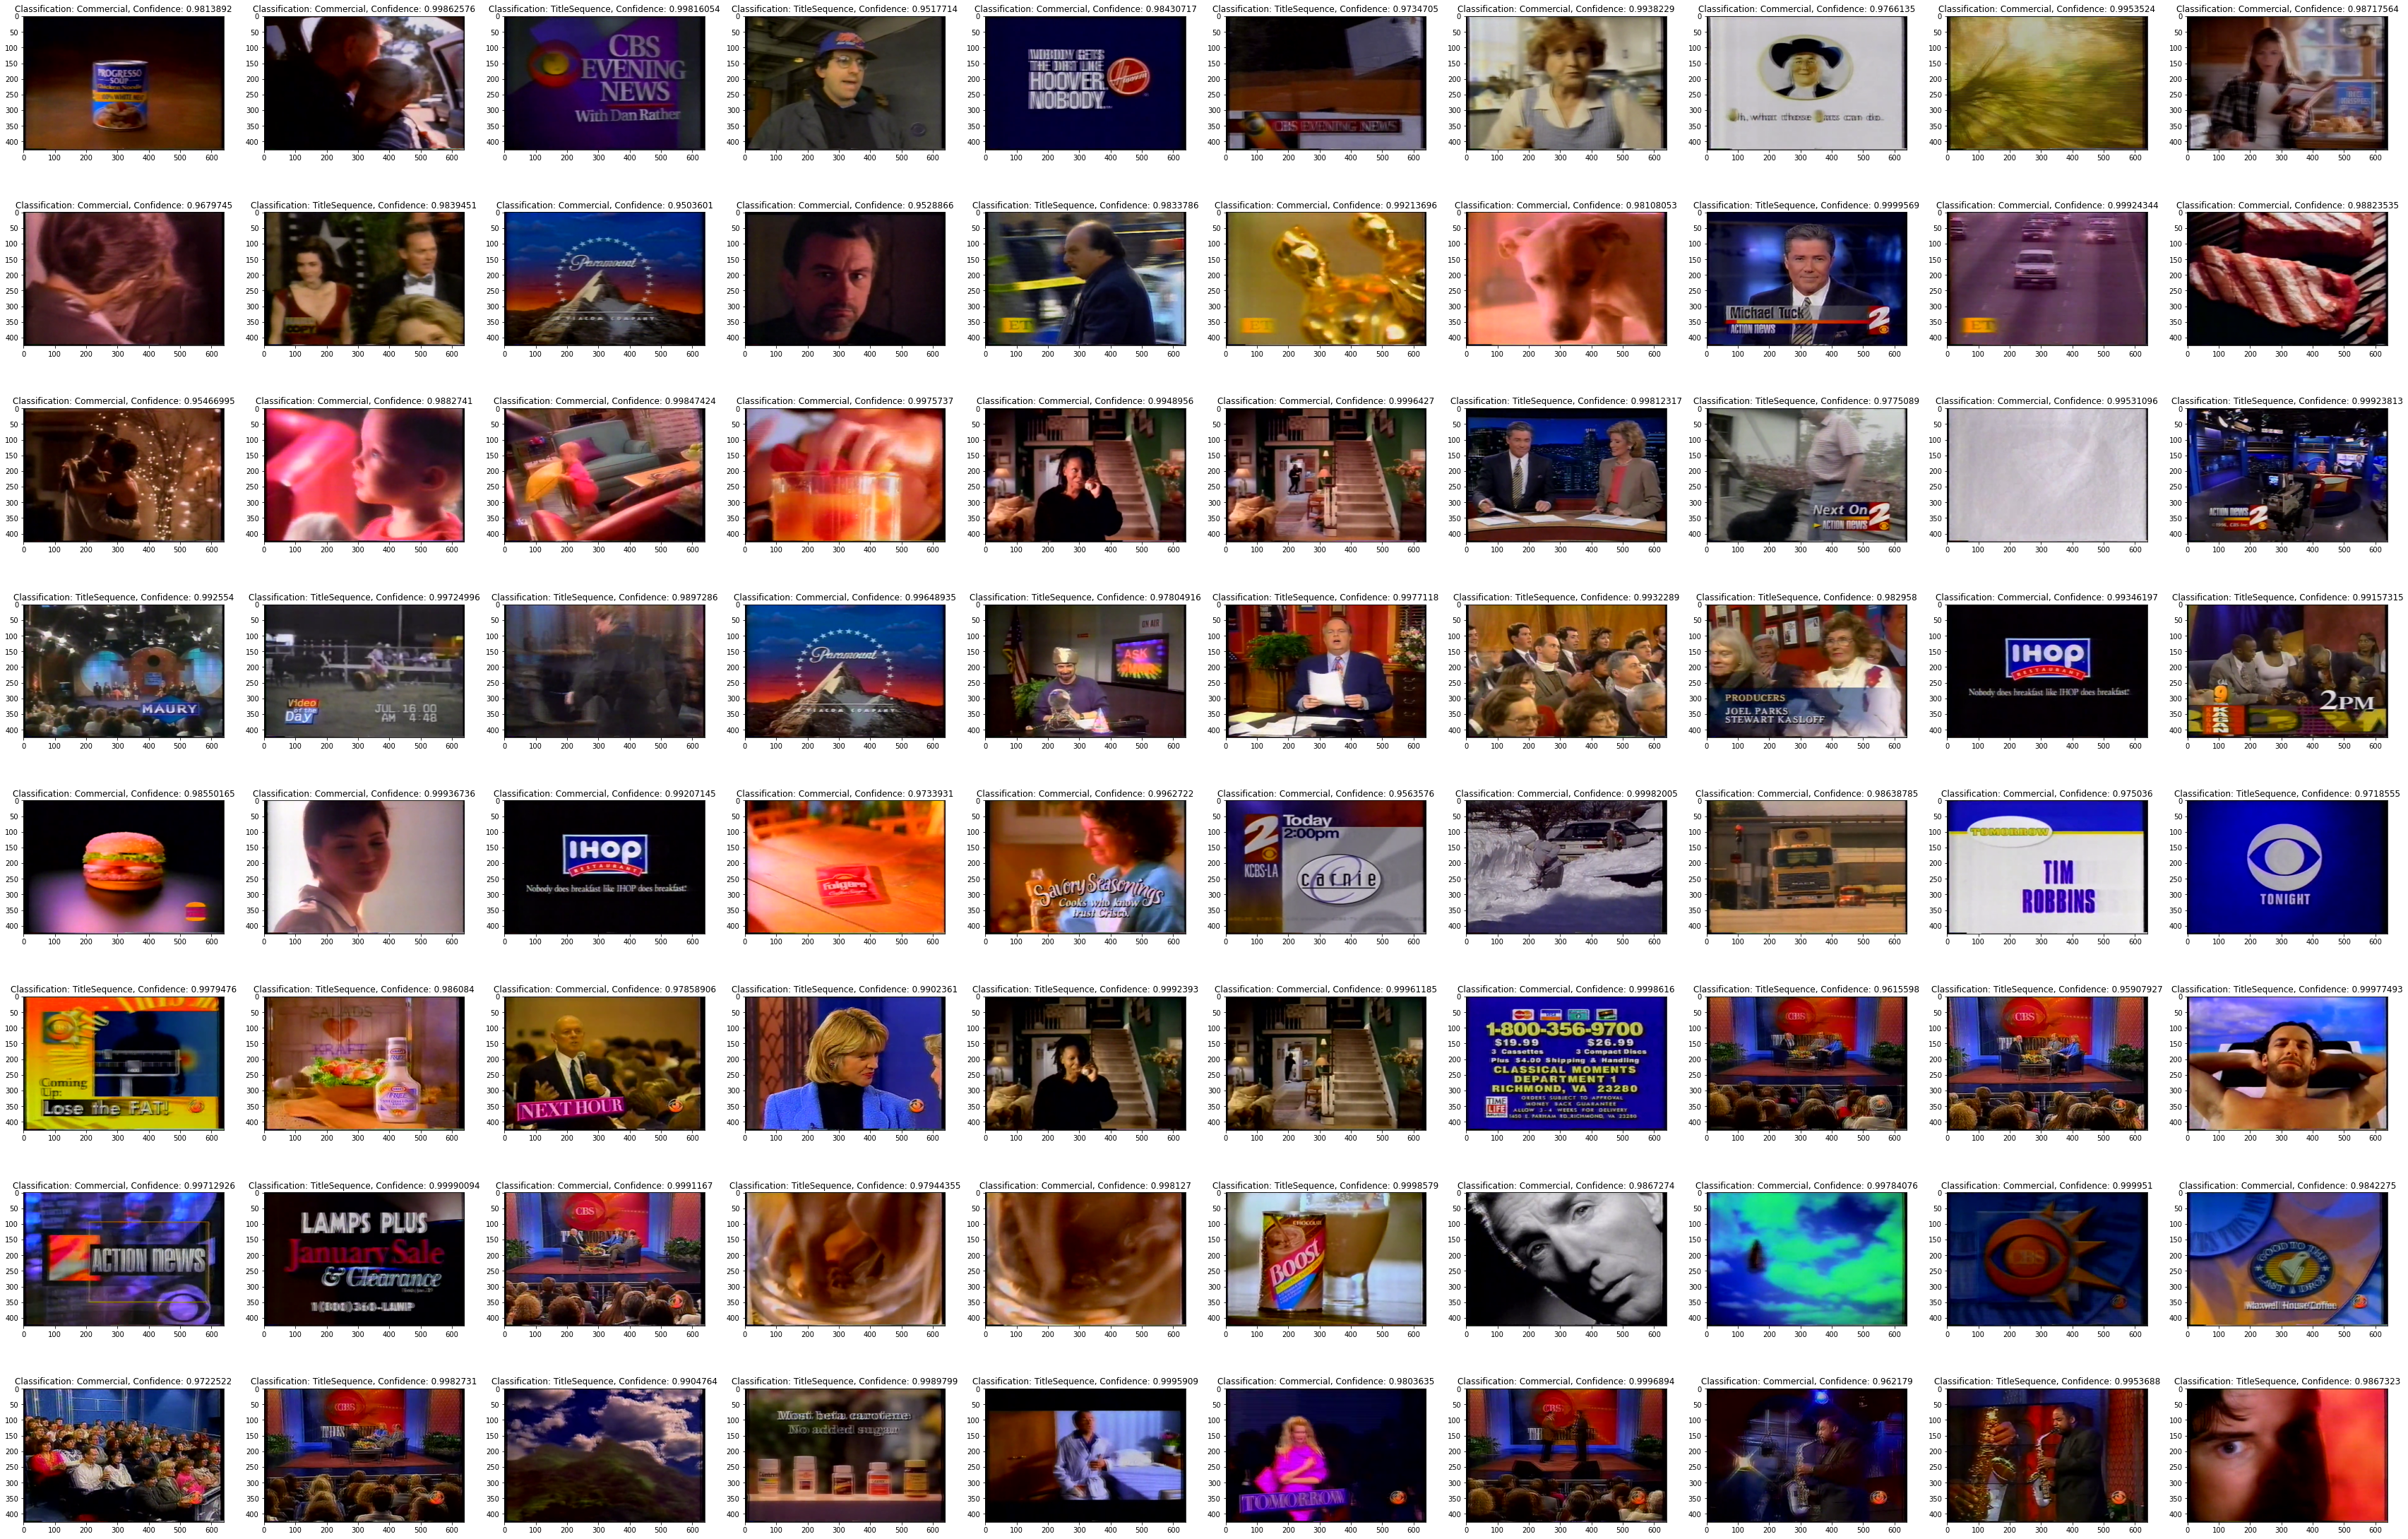

In [57]:
fig, axs = plt.subplots(nrows=8, ncols=10, figsize=(60,40))

for j, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(img_array[j])
    plt.title('Classification: {}, Confidence: {}'.format(image_filtered_clean_df['label'].iloc[j],
                                                     image_filtered_clean_df['confidence'].iloc[j]))

plt.show()
plt.savefig()